In [1]:
import math
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import cv2
import imageio

d:\Anaconda\Anaconda_setup\envs\viser_9\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Some tools for project:

In [4]:
def show_results(imgs, names):
    fig = plt.figure(figsize=(15,10))
    
    assert(len(imgs) == len(names))
    length = len(imgs)
    
    for i in range(length):
        ax = fig.add_subplot(1, length, i+1)
        ax.imshow(imgs[i])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel(names[i])
        
    plt.show()

### Part 1: Fit a Neural Field to a 2D Image

#### 1.1 build a dataloader:
##### Input: (N, pt) [pt = (x,y)] <br>
##### Label: (N, RGB) [RGB = (R,G,B)]

In [5]:
class CustomDataset(Dataset):
    def __init__(self, image_path, mode = "train"):
        self.image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
        self.height, self.width, _ = self.image.shape
        self.mode = mode

    def __len__(self):
        # Return the size of the dataset
        # so in one epoch, dataloader will return (height * width / batch_size) times
        return self.height * self.width

    def __getitem__(self, idx):
        # idx will +=1 automatically when dataloader get data
        # Generate random row and column indices
        
        if(self.mode == 'train'):
            row = np.random.randint(self.height)
            col = np.random.randint(self.width)
        elif(self.mode == 'test'):
            row = idx // self.width
            col = idx % self.width

        # Get the RGB values of the selected pixel position as labels
        # And normalize RGB values to the range [0, 1]
        labels = self.image[row, col] / 255.0

        # Convert the pixel position to coordinate form
        coords = (row / self.height, col / self.width)

        # Convert the coordinates and labels to PyTorch Tensor data type
        coords_tensor = torch.tensor(coords, dtype=torch.float32)
        labels_tensor = torch.tensor(labels, dtype=torch.float32)

        # Return the data
        return coords_tensor, labels_tensor

#### Check if CustomDataset works well

In [6]:
# Create an instance of the dataset
image_path = "images/part1/fox.jpg"
dataset = CustomDataset(image_path)

# Create a DataLoader instance, specifying the batch_size and other parameters
batch_size = 10000
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Iterate over the data using the DataLoader
index = 0
for coords, labels in dataloader:
    # Perform training or other operations here
    if(index == 0):
        print("Batch size:", coords.shape[0])  # Print the size of each batch
        print("Input shape:", coords.shape)  # Print the shape of the input
        print("Label shape:", labels.shape)  # Print the shape of the labels
    index += 1
    
print(f"{index} batch in total, (batch_size = {batch_size})")

Batch size: 10000
Input shape: torch.Size([10000, 2])
Label shape: torch.Size([10000, 3])
71 batch in total, (batch_size = 10000)


#### 1.2 build MLP model:

##### 1.2.1 Try Sinusoidal_Positional_Encoding

In [7]:
freq = 2 ** torch.arange(0,10) * math.pi
print(f"freq: {freq}")
x = tensor = torch.ones(2, 2)
y = x[:,:,None] * freq
y = y.permute(0,2,1)
y = y.reshape(y.shape[0],y.shape[1]*y.shape[2])
print(f"y's shape: {y.shape}")
r1 = torch.sin(y)
r2 = torch.cos(y)

print(f"r1: ", r1)
print(f"r2: ", r2)

pos_enc = torch.zeros((2, 42))
pos_enc[:,0:2] = x
#pos_enc[:,2::2] = r1
#pos_enc[:,3::2] = r2
pos_enc[:, 2::4] = r1[:,0::2]
pos_enc[:, 3::4] = r1[:,1::2]
pos_enc[:, 4::4] = r2[:,0::2]
pos_enc[:, 5::4] = r2[:,1::2]

print(f"pos_enc's shape: {pos_enc.shape}")
print(f"pos_enc: ", pos_enc)


freq: tensor([   3.1416,    6.2832,   12.5664,   25.1327,   50.2655,  100.5310,
         201.0619,  402.1239,  804.2477, 1608.4955])
y's shape: torch.Size([2, 20])
r1:  tensor([[-8.7423e-08, -8.7423e-08,  1.7485e-07,  1.7485e-07,  3.4969e-07,
          3.4969e-07,  6.9938e-07,  6.9938e-07,  1.3988e-06,  1.3988e-06,
          2.7975e-06,  2.7975e-06,  5.5951e-06,  5.5951e-06,  1.1190e-05,
          1.1190e-05,  2.2380e-05,  2.2380e-05,  4.4760e-05,  4.4760e-05],
        [-8.7423e-08, -8.7423e-08,  1.7485e-07,  1.7485e-07,  3.4969e-07,
          3.4969e-07,  6.9938e-07,  6.9938e-07,  1.3988e-06,  1.3988e-06,
          2.7975e-06,  2.7975e-06,  5.5951e-06,  5.5951e-06,  1.1190e-05,
          1.1190e-05,  2.2380e-05,  2.2380e-05,  4.4760e-05,  4.4760e-05]])
r2:  tensor([[-1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.,  1.,  1.,  1.,  1.],
        [-1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.,  1.,  1.,  1.,

##### 1.2.2 build MLP model with pe

In [6]:
class Sinusoidal_Positional_Encoding(nn.Module):
    def __init__(self, input_size, max_freq_level):
        super(Sinusoidal_Positional_Encoding, self).__init__()
        
        self.input_size = input_size
        self.max_freq_level = max_freq_level
        
    def forward(self, x):
        batch_size = x.size(0)
        seq_len = x.size(1)
        pos_enc = torch.zeros((batch_size, seq_len + seq_len * 2 * self.max_freq_level)).to(device)
        # shape: [batch_size, seq_len(2) * 2 * max_freq_level + seq_len(2)]
        
        freqs = (2 ** torch.arange(0, self.max_freq_level).to(device)) * math.pi
        # even pos --> sin
        
        y = (x[:,:,None] * freqs).permute(0,2,1)
        # y.shape: [batch_size, max_freq_level, seq_len]
        y = y.reshape(batch_size, seq_len*self.max_freq_level)
        # y.shape: [batch_size, seq_len * max_freq_level]
        
        #pos_enc[:, 0:2] = x
        #pos_enc[:, 2::2] = torch.sin(y)
        #pos_enc[:, 3::2] = torch.cos(y)
    
        pos_enc[:, 0:2] = x
        pos_enc[:, 2::4] = torch.sin(y[:,0::2])
        pos_enc[:, 3::4] = torch.sin(y[:,1::2])
        pos_enc[:, 4::4] = torch.cos(y[:,0::2])
        pos_enc[:, 5::4] = torch.cos(y[:,1::2])
        
        return pos_enc
        


class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, max_freq_level):
        super(MLP, self).__init__()
        
        self.pe = Sinusoidal_Positional_Encoding(input_size, max_freq_level)
        self.pe = self.pe.to(device)
        # output size of pe
        input_size = input_size * 2 * max_freq_level + input_size
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = self.pe(x)
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.relu3(self.fc3(x))
        x = self.fc4(x)
        x = torch.sigmoid(x)
        return x

#### Check if MLP with pe works well

In [9]:
input_size = 2
hidden_size = 256
output_size = 3
max_freq_level = 10
batch_size = 10000

model = MLP(input_size,hidden_size,output_size,max_freq_level)
model = model.to(device)
input_shape = (input_size,)
summary(model, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
Sinusoidal_Positional_Encoding-1                   [-1, 42]               0
            Linear-2                  [-1, 256]          11,008
              ReLU-3                  [-1, 256]               0
            Linear-4                  [-1, 256]          65,792
              ReLU-5                  [-1, 256]               0
            Linear-6                  [-1, 256]          65,792
              ReLU-7                  [-1, 256]               0
            Linear-8                    [-1, 3]             771
Total params: 143,363
Trainable params: 143,363
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.55
Estimated Total Size (MB): 0.56
----------------------------------------------------------------


#### 1.3 loss_fn and optimizer

In [7]:
# MSE loss has been included in torch.nn
def MSE_loss():
    return nn.MSELoss()

def Compute_PSNR(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    max_value = np.max(y_true)
    psnr = 10 * np.log10(max_value / np.sqrt(mse))
    return psnr

# psnr_loss needs to be defined based on nn.Module
class PSNR_loss(nn.Module):
    def __init__(self, max_val=1.0):
        super(PSNR_loss, self).__init__()
        self.max_val = max_val
        
    def forward(self, y_true, y_pred):
        mse = MSE_loss()(y_true, y_pred)
        psnr = -10 * torch.log10(self.max_val**2 / mse)
        return psnr
    
def create_loss_fn(kind = "psnr"):
    if(kind == "mse"):
        return MSE_loss()
    elif(kind == "psnr"):
        return PSNR_loss(max_val=1.0)
    else:
        raise ValueError(f"wrong loss_fn kind {kind}")
    
def create_optimizer(model, lr=0.001):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    return optimizer

def create_scheduler(optimizer, num_epoch, kind = "plateau"):
    """
    scheduler kind:
    plateau: ReduceLROnPlateau
    cosine: CosineAnnealingLR
    """
    
    if(kind == "plateau"):
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
    elif(kind == "cosine"):
        scheduler = CosineAnnealingLR(optimizer, T_max=num_epoch)
    else:
        raise ValueError(f"wrong scheduler {kind}")
    
    return scheduler

#### 1.4 train and test

In [8]:
def reconstruct_img(model, param):
    img_path = param['img_path']
    batch_size = param['batch_size']
    dataset = CustomDataset(img_path, mode = "test")
    dataloader = DataLoader(dataset, batch_size=10000, shuffle=False)
    
    image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    height, width, channel = image.shape
    re_image = np.zeros((height*width, channel))
    
    #print(image.shape)
    #print(re_image.shape)
    
    index = 0
    with torch.no_grad():
        for coords, labels in dataloader:
            coords = coords.to(device)
            y_pred = model(coords)
            y_pred = y_pred.cpu().numpy()

            batch_size = y_pred.shape[0]
            y_pred = y_pred.reshape(batch_size, -1)

            re_image[index:index+batch_size] = y_pred
            index += batch_size
        
    re_image = re_image.reshape(height, width, channel)
    return re_image 

In [27]:
def train(model, param):
    lr = param['lr']
    iterations = param['iter']
    train_loss = param['train_loss']
    test_loss = param['test_loss']
    batch_size = param['batch_size']
    img_path = param['img_path']
    scheduler_kind = param['scheduler']
    save_log = param['save_log']
    logs_dir = param['logs_dir']
    save_model = param['save_model']
    save_mid = param['save_mid']
    save_mid_dir = param['save_mid_dir']
    
    img_name = os.path.basename(img_path).split('.')[0]
    folder_name = f"{img_name}_{lr}_{iterations}_{train_loss}_{test_loss}_{scheduler_kind}"
    if(save_log):
        save_path = logs_dir + folder_name + "/"
        writer = SummaryWriter(save_path)
    
    dataset = CustomDataset(img_path, mode = "train")
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    loss_fn = create_loss_fn(kind = train_loss)
    optimizer = create_optimizer(model=model, lr=lr)
    scheduler = create_scheduler(optimizer, iterations, scheduler_kind)
    
    for i in range(iterations):
        print(f"epoch {i+1}:")
        total_loss = 0
        samples = 0
        for coords, labels in dataloader:
            coords = coords.to(device)
            labels = labels.to(device)
            
            y_pred = model(coords)
            loss = loss_fn(labels, y_pred)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += (loss.item() * coords.size(0))
            samples += coords.size(0)
            
        train_loss = total_loss / samples
        print(f"train loss: {train_loss}")
        test_loss = test(model,param)
        print(f"test loss: {test_loss}")
        origin_image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB) / 255.0
        recon_image = reconstruct_img(model, param)
        psnr = Compute_PSNR(origin_image, recon_image)
        print(f"PSNR: {psnr}")
        
        if(save_log):
            writer.add_scalar("train_loss", train_loss, i)
            writer.add_scalar("test_loss", test_loss, i)
            writer.add_scalar("PSNR", psnr, i)
            
        if(save_mid and ((i+1) % 5 == 0)):
            save_path = f"{save_mid_dir}{str(i+1)}.jpg"
            plt.imshow(recon_image)
            plt.axis('off')
            plt.savefig(save_path)
        
        if(scheduler_kind == "plateau"):
            scheduler.step(test_loss)
        elif(scheduler_kind == "cosine"):
            scheduler.step()
        else:
            raise ValueError(f"wrong scheduler {scheduler_kind}") 
        
    if(save_log):
        writer.close()
        
    if(save_model):
        model_path = "checkpoints/" + folder_name + ".pt"
        torch.save(model.state_dict(), model_path)
        
    return model
        
        
def test(model, param):
    loss = param['test_loss']
    img_path = param['img_path']
    batch_size = param['batch_size']
    
    dataset = CustomDataset(img_path, mode = "test")
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    loss_fn = create_loss_fn(kind = loss)
    
    total_loss = 0
    samples = 0
    for coords, labels in dataloader:
        coords = coords.to(device)
        labels = labels.to(device)
        
        y_pred = model(coords)
        loss = loss_fn(labels, y_pred)
        
        total_loss += (loss.item() * coords.size(0))
        samples += coords.size(0)
        
    test_loss = total_loss / samples
    return test_loss

In [28]:
param = {
    "lr" : 0.01,
    "iter" : 80,
    "train_loss" : "mse",
    "test_loss" : "mse",
    "batch_size" : 10000,
    "scheduler" : "plateau",
    "img_path" : "images/part1/fox.jpg",
    "save_log" : True,
    "logs_dir" : "logs/",
    "save_model" : True,
    "save_mid" : True,
    "save_mid_dir" : "results/part1/"
}

epoch 1:
train loss: 0.03774565236532033
test loss: 0.009473095270549082
PSNR: 10.11754048793027
epoch 2:
train loss: 0.005881772861002518
test loss: 0.004403850448689586
PSNR: 11.780837118293167
epoch 3:
train loss: 0.003990464482683447
test loss: 0.003672642971786892
PSNR: 12.17510648818924
epoch 4:
train loss: 0.0034765630205581236
test loss: 0.0038194015836547405
PSNR: 12.090023166194538
epoch 5:
train loss: 0.0033175310859451927
test loss: 0.0032726179921506687
PSNR: 12.425523358230459
epoch 6:
train loss: 0.0031409572080448585
test loss: 0.003040073189779678
PSNR: 12.585579873297032
epoch 7:
train loss: 0.0030037107440896963
test loss: 0.002866847318120895
PSNR: 12.712977195766278
epoch 8:
train loss: 0.0028874120344472907
test loss: 0.002933966961685555
PSNR: 12.662723793897763
epoch 9:
train loss: 0.002872769148116237
test loss: 0.0030691324223149365
PSNR: 12.564921697432318
epoch 10:
train loss: 0.0027952053129828196
test loss: 0.0027249790348394657
PSNR: 12.823184237490544
ep

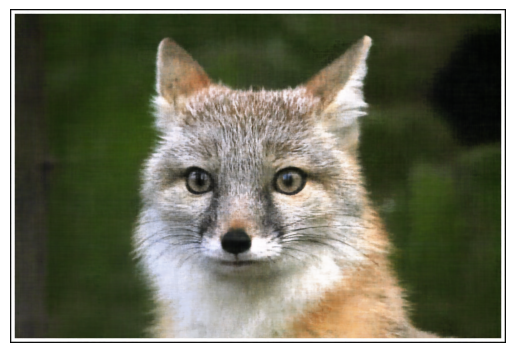

In [29]:
model = MLP(2,256,3,10)
model = model.to(device)

model = train(model, param)

In [10]:
model = MLP(2,256,3,10)
model.load_state_dict(torch.load("checkpoints/MLP.pt"))
model = model.to(device)

#### 1.5 check reconstruct result

In [31]:
image = cv2.cvtColor(cv2.imread(param['img_path']), cv2.COLOR_BGR2RGB)
re_image = reconstruct_img(model, param)

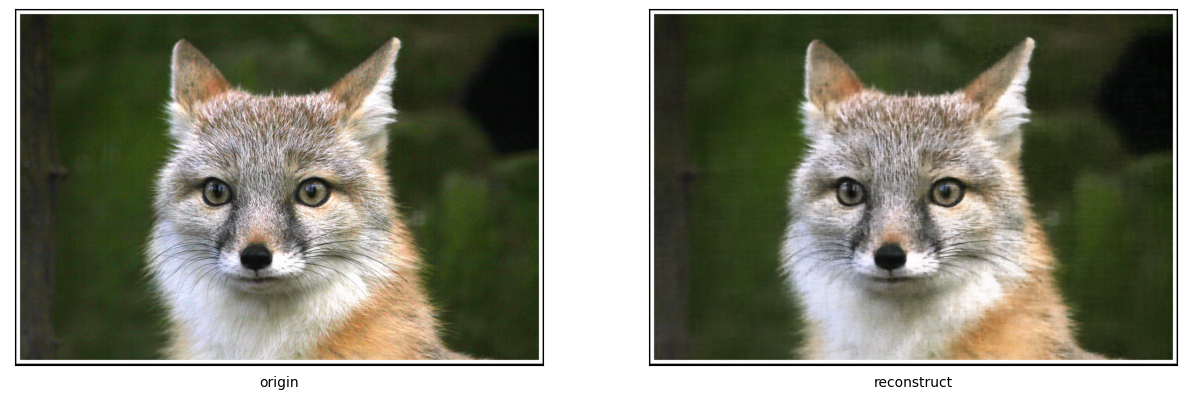

In [32]:
imgs = [image, re_image]
names = ["origin", "reconstruct"]
show_results(imgs, names)

### Part 2: Fit a Neural Radiance Field from Multi-view Images

#### Part 2.0 Show images

In [5]:
data = np.load(f"images/part2/lego_200x200.npz")

# Training images: [100, 200, 200, 3]
images_train = data["images_train"] / 255.0

# Cameras for the training images 
# (camera-to-world transformation matrix): [100, 4, 4]
c2ws_train = data["c2ws_train"]

# Validation images: 
images_val = data["images_val"] / 255.0

# Cameras for the validation images: [10, 4, 4]
# (camera-to-world transformation matrix): [10, 200, 200, 3]
c2ws_val = data["c2ws_val"]

# Test cameras for novel-view video rendering: 
# (camera-to-world transformation matrix): [60, 4, 4]
c2ws_test = data["c2ws_test"]

# Camera focal length
focal = data["focal"]  # float

num of train_data: 100
train_data[:5]


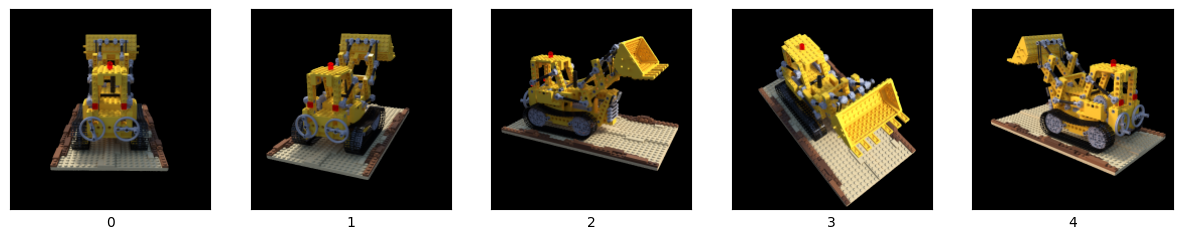

In [6]:
print(f"num of train_data: {images_train.shape[0]}")
print("train_data[:5]")
show_results(images_train[0:5], [str(i) for i in range(5)])

In [7]:
print("example of train camera-to-world transformation matrix")
print(c2ws_train[0])

example of train camera-to-world transformation matrix
[[-9.99902189e-01 -4.19224519e-03  1.33457193e-02 -5.37983216e-02]
 [-1.39886811e-02  2.99659073e-01 -9.53943670e-01  3.84547043e+00]
 [-4.65661287e-10 -9.54037189e-01 -2.99688309e-01  1.20808232e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


num of val_data: 10
val_data[:5]


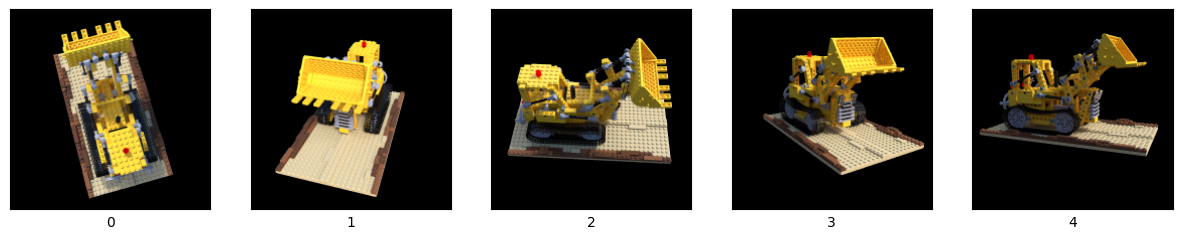

In [8]:
print(f"num of val_data: {images_val.shape[0]}")
print("val_data[:5]")
show_results(images_val[0:5], [str(i) for i in range(5)])

In [9]:
print("example of val camera-to-world transformation matrix")
print(c2ws_val[:1])

example of val camera-to-world transformation matrix
[[[-9.63964581e-01  2.61140168e-01 -5.07759266e-02  2.04684302e-01]
  [ 2.66030818e-01  9.46243346e-01 -1.83986932e-01  7.41675019e-01]
  [ 7.45058060e-09 -1.90864936e-01 -9.81616318e-01  3.95702195e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]]


In [10]:
print("Camera focal length:")
print(focal)

Camera focal length:
277.77775779844205


#### Part 2.1: Create Rays from Cameras

##### 2.1.1: Camera to World Coordinate Conversion.

In [6]:
# x_w = transform(c2w, x_c)

def transform(c2w_s, p_c_s):
    """_summary_

    Args:
        c2w_s (N, 4, 4): N camera-to-world transformation matrix
        p_c_s (N, 4): N positions of points in cameras (each one in (xc, yc, zc, 1))
    """
    
    p_w_s = np.einsum('...ij,...j->...i', c2w_s, p_c_s)
    return p_w_s

##### check the transform function

In [8]:
train_num = c2ws_train.shape[0]
shape = (train_num, 4)
train_p_c_s = np.random.random(shape)
train_p_c_s[:,-1] = 1
train_p_w_s = transform(c2ws_train, train_p_c_s)
assert(train_p_w_s.shape == shape)

new_train_p_c_s = transform(np.linalg.inv(c2ws_train), train_p_w_s)
assert(train_p_c_s.any() == new_train_p_c_s.any())
print("transform works well!")

transform works well!


##### 2.1.2: Pixel to Camera Coordinate Conversion.

In [7]:
# x_c = pixel_to_camera(K, uv, s)

def pixel_to_camera(K, uv_s, s_s):
    """_summary_

    Args:
        K (3,3): intrinsic matrix K
        uv_s (N, 3): N positions of points in pixel coordinate system (each one in (u, v, 1))
        s_s (N): s = Zc is the depth of this point along the optical axis
    """
    
    p_c_s = (np.linalg.inv(K) @ (uv_s * s_s[:, np.newaxis]).T).T
    return p_c_s

def camera_to_pixel(K, p_c_s):
    """_summary_

    Args:
        K (3,3): intrinsic matrix K
        p_c_s (N, 3): N positions of points in cameras (each one in (xc, yc, zc))
    """
    
    s_s = p_c_s[:, -1]
    s_uv_s = np.einsum('ij,nj->ni', K, p_c_s)
    # s_uv_s shape: (N,3)
    uv_s = s_uv_s / s_s[:, np.newaxis]
    return uv_s
    

##### check pixel_to_camera function

In [9]:
clip_train_p_c_s = train_p_c_s[:,:3]
s_s = clip_train_p_c_s[:,-1]
#s_s = np.ones((clip_train_p_c_s.shape[0]))

train_num, height, width, _ = images_train.shape
o_x, o_y = height / 2, width / 2

K = np.array([[focal, 0, o_x],
              [0, focal, o_y],
              [0, 0,     1 ]])

uv_s = camera_to_pixel(K, clip_train_p_c_s)
assert(uv_s.shape == (train_num, 3))
new_clip_train_p_c_s = pixel_to_camera(K, uv_s, s_s)
assert(clip_train_p_c_s.any() == new_clip_train_p_c_s.any())
print("pixel_to_camera and camera_to_pixel work well!")

pixel_to_camera and camera_to_pixel work well!


##### 2.1.3: Pixel to Ray。

In [10]:
p_c_s = pixel_to_camera(K, uv_s, s_s)
ones = np.ones((p_c_s.shape[0], 1))
p_c_s = np.concatenate((p_c_s, ones), axis=1)

p_w_s = transform(c2ws_train, p_c_s)
R_s = c2ws_train[:, :3, :3]
t_s = c2ws_train[:, :3, 3]
R_inv_s = np.linalg.inv(R_s)

print(f"R_inv_s shape: {R_inv_s.shape}")
print(f"t_s shape: {t_s.shape}")

r = -R_inv_s @ t_s[:, :, np.newaxis]
r = r.squeeze()
r.shape


R_inv_s shape: (100, 3, 3)
t_s shape: (100, 3)


(100, 3)

In [8]:
# ray_o, ray_d = pixel_to_ray(K, c2w, uv)

def pixel_to_ray(K, c2w_s, uv_s):
    """_summary_

    Args:
        K (3,3): intrinsic matrix K
        c2w_s (N, 4, 4): N camera-to-world transformation matrix
        uv_s (N, 3): N positions of points in pixel coordinate system (each one in (u, v, 1))
        s_s (N): s = 1 is the depth of this point along the optical axis
    """
    
    #print("K: ", K)
    #print("uv_s[:2]: ",uv_s[:2])
    
    s_s = np.ones(uv_s.shape[0])
    p_c_s = pixel_to_camera(K, uv_s, s_s)
    ones = np.ones((p_c_s.shape[0], 1))
    p_c_s = np.concatenate((p_c_s, ones), axis=1)
    #print("p_c_s: \n", p_c_s[:2])
    p_w_s = transform(c2w_s, p_c_s)
    #print("p_w_s: \n", p_w_s[:2])
    
    R_s = c2w_s[:, :3, :3]
    #t_s = c2w_s[:, :3, 3]
    t_s = (np.linalg.inv(c2w_s))[:, :3, 3]
    
    r_o = (-R_s @ t_s[:, :, np.newaxis]).squeeze()
    
    #print("c2w_s[:2]: \n", c2w_s[:2])
    #print("R_s[:2]: \n", R_s[:2])
    #print("t_s[:2]: \n", t_s[:2])
    #print("R_inv_s shape: ", R_inv_s.shape)
    #print("R_inv_s[:2]: \n", R_inv_s[:2])
    #print("t_s shape: ", t_s.shape)
    #print("t_s[:2]: \n", t_s[:2])
    #print("r_o[:2]: \n", r_o[:2])
    
    sample_p_w = p_w_s[:, :3]
    diff = sample_p_w - r_o
    distance = np.linalg.norm(diff, axis=1)
    #print("l1_norm: ", l1_norm[:2])
    #print("cha: ", diff[:2])
    r_d = (sample_p_w - r_o) / distance[:, np.newaxis]
    #print("r_d: \n", r_d[:2])
    
    return r_o, r_d

##### check pixel_to_ray function

In [12]:
r_o, r_d = pixel_to_ray(K, c2ws_train, uv_s)
assert(r_o.shape == (train_num, 3))
assert(r_d.shape == (train_num, 3))
print("pixel_to_ray work well!")

pixel_to_ray work well!


#### Part 2.2: Sampling

##### We define a new dataset in pytorch in order to sample

In [34]:
class Ray_Dataset(Dataset):
    def __init__(self, data, mode = "train", batch_size = 10000):
        if(mode == "train"):
            self.images = data['images_train'] / 255.0
            self.c2ws = data['c2ws_train']
        elif(mode == "val"):
            self.images = data['images_val'] / 255.0
            self.c2ws = data['c2ws_val']
        elif(mode == "test"):
            #self.images = data['images_test']
            self.c2ws = data['c2ws_test']
            num = self.c2ws.shape[0]
            _, height, width, channel = data['images_train'].shape
            self.images = np.zeros((num, height, width, channel))
        else:
            raise ValueError(f"wrong mode {mode}")
        
        self.focal = data['focal']
        self.num, self.height, self.width, channels = self.images.shape
        self.o_x, self.o_y = self.height / 2, self.width / 2
        self.K = np.array([[self.focal, 0, self.o_x],
                           [0, self.focal, self.o_y],
                           [0,          0,        1]])
        self.pixels = self.num * self.height * self.width
        self.mode = mode
        self.N = batch_size
        self.flattened_images = self.images.reshape(self.pixels, channels)

    def __len__(self):
        # Return the size of the dataset
        return self.pixels // self.N

    def __getitem__(self, idx):
        # idx will +=1 automatically when dataloader get data
        # Generate random row and column indices
        
        if(self.mode == 'train'):
            index = np.random.choice(self.pixels, size=self.N, replace=False)
        elif(self.mode == 'test' or self.mode == 'val'):
            index = np.arange(idx*self.N, (idx+1) * self.N)

        u_s = (index % (self.height * self.width)) // self.height
        v_s = (index % (self.height * self.width)) % self.height
        
        #print("index: \n", index)
        #print("u_s: \n", u_s)
        #print("v_s: \n", v_s)
        #print(self.K)
        
        # make sure to account for the offset from image coordinate to pixel center 
        # (this can be done simply by adding .5 to your UV pixel coordinate grid)
        u_s = u_s + 0.5
        v_s = v_s + 0.5
        
        coords = np.column_stack((u_s, v_s, np.ones(self.N)))
        
        c2w_index = index // (self.height * self.width)
        #print("c2w_index:")
        #print(c2w_index)
        c2w_s = self.c2ws[c2w_index]

        r_o, r_d = pixel_to_ray(self.K, c2w_s, coords)
        #print("r_o:")
        #print(r_o)
        #print("r_d:")
        #print(r_d)
        labels = self.flattened_images[index]
        #print("labels:")
        #print(labels)

        # Convert the coordinates and labels to PyTorch Tensor data type
        r_o_tensor = torch.tensor(r_o, dtype=torch.float32)
        r_d_tensor = torch.tensor(r_d, dtype=torch.float32)
        labels_tensor = torch.tensor(labels, dtype=torch.float32)

        # Return the data
        return r_o_tensor, r_d_tensor, labels_tensor

##### Check if Ray_Dataset works well

In [14]:
batch_size = 10000
dataset = Ray_Dataset(mode = "train", data = data, batch_size = batch_size)
dataloader = DataLoader(dataset, batch_size=None, collate_fn=None)

# Iterate over the data using the DataLoader
print("\nin train mode:")
index = 0
for r_o, r_d, labels in dataloader:
    # Perform training or other operations here
    if(index == 0):
        print("Batch size:", r_o.shape[0])  # Print the size of each batch
        print("r_o shape:", r_o.shape)      # Print the shape of the r_o
        print("r_d shape:", r_d.shape)      # Print the shape of the r_d
        print("Label shape:", labels.shape)  # Print the shape of the labels
        break
    index += 1
    
print(f"{index} iter in total")

"""

dataset = Ray_Dataset(mode = "val", data = data, batch_size = batch_size)
dataloader = DataLoader(dataset, batch_size=None, collate_fn=None)

print("\nin val mode:")
index = 0
for r_o, r_d, labels in dataloader:
    # Perform training or other operations here
    if(index == 0):
        print("Batch size:", r_o.shape[0])  # Print the size of each batch
        print("r_o shape:", r_o.shape)      # Print the shape of the r_o
        print("r_d shape:", r_d.shape)      # Print the shape of the r_d
        print("Label shape:", labels.shape)  # Print the shape of the labels
    index += 1
    
print(f"{index} iter in total")
"""




in train mode:
Batch size: 10000
r_o shape: torch.Size([10000, 3])
r_d shape: torch.Size([10000, 3])
Label shape: torch.Size([10000, 3])
0 iter in total


'\n\ndataset = Ray_Dataset(mode = "val", data = data, batch_size = batch_size)\ndataloader = DataLoader(dataset, batch_size=None, collate_fn=None)\n\nprint("\nin val mode:")\nindex = 0\nfor r_o, r_d, labels in dataloader:\n    # Perform training or other operations here\n    if(index == 0):\n        print("Batch size:", r_o.shape[0])  # Print the size of each batch\n        print("r_o shape:", r_o.shape)      # Print the shape of the r_o\n        print("r_d shape:", r_d.shape)      # Print the shape of the r_d\n        print("Label shape:", labels.shape)  # Print the shape of the labels\n    index += 1\n    \nprint(f"{index} iter in total")\n'

##### Sampling Points along Rays:

In [39]:
def sample_along_rays(rays_o, rays_d, param):
    """_summary_

    Args:
        rays_o (N, 3): location of the cameras
        rays_d (N, 3): ray direction
        param  (dict): some hyper param
        perturb (bool, optional): reduce overfitting. Defaults to True.
    """
    
    rays_o = rays_o.numpy()
    rays_d = rays_d.numpy()
    
    near = param['near']
    far = param['far']
    n_samples = param['n_samples']
    perturb = param['perturb']
    
    # x = R_o + R_d * t
    # t = np.linspace(near, far, n_samples)
    # t = t + np.random((far - near) / n_samples)
    
    N = rays_o.shape[0]
    t = np.linspace(near, far, n_samples)
    t_s = np.broadcast_to(t, (N, n_samples))
    
    # t = t + (np.random.rand(t.shape) * t_width)
    if(perturb):
        perturbation = np.random.rand(N,n_samples) * ((far - near) / n_samples)
        t_s = t_s + perturbation
        
    #N = rays_o.shape[0]
    #t_s = np.broadcast_to(t, (N, t.shape[0]))
    
    rays_o_e = np.expand_dims(rays_o, axis=1)
    rays_d_e = np.expand_dims(rays_d, axis=1)
    
    pts = rays_o_e + rays_d_e * t_s[:,:,np.newaxis]
    pts = pts.reshape(pts.shape[0]*pts.shape[1], pts.shape[2])
    pts = torch.tensor(pts, dtype=torch.float32)
    
    rays_s_d = np.tile(rays_d[:, np.newaxis, :], (1, n_samples, 1))
    rays_s_d = rays_s_d.reshape(rays_s_d.shape[0]*rays_s_d.shape[1], rays_s_d.shape[2])
    rays_s_d = torch.tensor(rays_s_d, dtype=torch.float32)
    
    #print("o: \n", rays_o[0])
    #print("d: \n", rays_d[0])
    #print("t: \n", t_s[0])
    #print("pt: \n", pts[0])
    
    return pts, rays_s_d
        

##### Check if sample_along_rays works well

In [40]:
param = {
    "data" : data,
    "near" : 2.0,
    "far" : 6.0,
    "n_samples" : 64,
    "perturb" : True,
    "batch_size" : 5000,
    "lr" : 1e-4,
    "iter" : 10,
    "freq" : [10,4],
    "scheduler" : "plateau",
    "save_log" : False,
    "logs_dir" : "logs/part2/",
    "save_model" : True,
    "save_mid" : True,
    "save_mid_dir" : "results/part2/"
}

batch_size = 10000
dataset = Ray_Dataset(mode = "train", data = data, batch_size = batch_size)
dataloader = DataLoader(dataset, batch_size=None, collate_fn=None)

# Iterate over the data using the DataLoader
print("\nin train mode:")
index = 0
for r_o, r_d, labels in dataloader:
    # Perform training or other operations here
    if(index == 0):
        print("Batch size:", r_o.shape[0])  # Print the size of each batch
        print("r_o shape:", r_o.shape)      # Print the shape of the r_o
        print("r_d shape:", r_d.shape)      # Print the shape of the r_d
        print("Label shape:", labels.shape)  # Print the shape of the labels
        
        pts, rays_s_d = sample_along_rays(r_o, r_d, param)
        print("sampled pts shape: ", pts.shape)
        print("sampled ray_d shape: ", rays_s_d.shape)
        print("sampled labels shape:", labels.shape)  # Print the shape of the labels
        
        #print("r_d: ", r_d)
        #print("rays_s_d: ", rays_s_d)
        
        break
    index += 1


in train mode:
Batch size: 10000
r_o shape: torch.Size([10000, 3])
r_d shape: torch.Size([10000, 3])
Label shape: torch.Size([10000, 3])
sampled pts shape:  torch.Size([640000, 3])
sampled ray_d shape:  torch.Size([640000, 3])
sampled labels shape: torch.Size([10000, 3])


#### Part 2.3: Putting the Dataloading All Together

In [41]:
import viser, time
np.set_printoptions(threshold=float('inf'))

##### http://localhost:8080

In [42]:
dataset = Ray_Dataset(data, mode = "train", batch_size=100)
dataloader = DataLoader(dataset, batch_size=None, collate_fn=None)

for rays_o, rays_d, labels in dataloader:
    points, rays_s_d = sample_along_rays(rays_o, rays_d, param)
    points = points.numpy()
    labels = labels.numpy()
    
    s_rays_o = rays_o.numpy()
    s_rays_d = rays_d.numpy()
    
    print(points.shape)
    #print(points)
    #print("rays_d: \n", rays_d)
    print(labels.shape)
    break

# ---------------------------------------
num , H, W, C = images_train.shape
focal = data['focal']
o_x, o_y = H / 2, W / 2

K = np.array([[focal, 0, o_x],
              [0, focal, o_y],
              [0, 0,     1 ]])

server = viser.ViserServer(share=True)
for i, (image, c2w) in enumerate(zip(images_train, c2ws_train)):
    server.add_camera_frustum(
    f"/cameras/{i}",
    fov=2 * np.arctan2(H / 2, K[0, 0]),
    aspect=W / H,
    scale=0.15,
    wxyz=viser.transforms.SO3.from_matrix(c2w[:3, :3]).wxyz,
    position=c2w[:3, 3],
    image=image
    )
for i, (o, d) in enumerate(zip(s_rays_o, s_rays_d)):
    server.add_spline_catmull_rom(
        f"/rays/{i}", positions=np.stack((o, o + d * 6.0)),
    )
server.add_point_cloud(
    f"/samples",
    colors=np.zeros_like(points).reshape(-1, 3),
    points=points.reshape(-1, 3),
    point_size=0.02,
)
time.sleep(60)

(6400, 3)
(100, 3)


(viser) Share URL requested! (expires in 24 hours)

╭──────────────────────────── viser ─────────────────────────────╮
│             ╷                                                  │
│   HTTP      │ http://0.0.0.0:8080                              │
│   Websocket │ ws://0.0.0.0:8080                                │
│   Share URL │ https://normalized-artboard.share.viser.studio   │
│             ╵                                                  │
╰────────────────────────────────────────────────────────────────╯

(viser) Connection opened (0, 1 total), 506 persistent messages

(viser) Connection opened (1, 2 total), 506 persistent messages

#### Part 2.4: Neural Radiance Field

In [53]:
freq = 2 ** torch.arange(0,10) * math.pi
print(f"freq: {freq}")
x = tensor = torch.ones(2, 3)
y = x[:,:,None] * freq
y = y.permute(0,2,1)
y = y.reshape(y.shape[0],y.shape[1]*y.shape[2])
print(f"y's shape: {y.shape}")
r1 = torch.sin(y)
r2 = torch.cos(y)

print(f"r1: ", r1)
print(f"r2: ", r2)

pos_enc = torch.zeros((2, 63))
pos_enc[:,0:3] = x
#pos_enc[:,2::2] = r1
#pos_enc[:,3::2] = r2
pos_enc[:, 3::6] = r1[:,0::3]
pos_enc[:, 4::6] = r1[:,1::3]
pos_enc[:, 5::6] = r1[:,2::3]
pos_enc[:, 6::6] = r2[:,0::3]
pos_enc[:, 7::6] = r2[:,1::3]
pos_enc[:, 8::6] = r2[:,2::3]

print(f"pos_enc's shape: {pos_enc.shape}")
print(f"pos_enc: ", pos_enc)

freq: tensor([   3.1416,    6.2832,   12.5664,   25.1327,   50.2655,  100.5310,
         201.0619,  402.1239,  804.2477, 1608.4955])
y's shape: torch.Size([2, 30])
r1:  tensor([[-8.7423e-08, -8.7423e-08, -8.7423e-08,  1.7485e-07,  1.7485e-07,
          1.7485e-07,  3.4969e-07,  3.4969e-07,  3.4969e-07,  6.9938e-07,
          6.9938e-07,  6.9938e-07,  1.3988e-06,  1.3988e-06,  1.3988e-06,
          2.7975e-06,  2.7975e-06,  2.7975e-06,  5.5951e-06,  5.5951e-06,
          5.5951e-06,  1.1190e-05,  1.1190e-05,  1.1190e-05,  2.2380e-05,
          2.2380e-05,  2.2380e-05,  4.4760e-05,  4.4760e-05,  4.4760e-05],
        [-8.7423e-08, -8.7423e-08, -8.7423e-08,  1.7485e-07,  1.7485e-07,
          1.7485e-07,  3.4969e-07,  3.4969e-07,  3.4969e-07,  6.9938e-07,
          6.9938e-07,  6.9938e-07,  1.3988e-06,  1.3988e-06,  1.3988e-06,
          2.7975e-06,  2.7975e-06,  2.7975e-06,  5.5951e-06,  5.5951e-06,
          5.5951e-06,  1.1190e-05,  1.1190e-05,  1.1190e-05,  2.2380e-05,
          2.2380

In [11]:
class Sinusoidal_Positional_Encoding_3D(nn.Module):
    def __init__(self, input_size, max_freq_level):
        super(Sinusoidal_Positional_Encoding_3D, self).__init__()
        
        self.input_size = input_size
        self.max_freq_level = max_freq_level
        
    def forward(self, x):
        batch_size = x.size(0)
        seq_len = x.size(1)
        pos_enc = torch.zeros((batch_size, seq_len + seq_len * 2 * self.max_freq_level)).to(device)
        # shape: [batch_size, seq_len(2) * 2 * max_freq_level + seq_len(2)]
        
        freqs = (2 ** torch.arange(0, self.max_freq_level).to(device)) * math.pi
        # even pos --> sin
        
        y = (x[:,:,None] * freqs).permute(0,2,1)
        # y.shape: [batch_size, max_freq_level, seq_len]
        y = y.reshape(batch_size, seq_len*self.max_freq_level)
        # y.shape: [batch_size, seq_len * max_freq_level]
        
        pos_enc[:, 0:3] = x
        pos_enc[:, 3::6] = torch.sin(y[:,0::3])
        pos_enc[:, 4::6] = torch.sin(y[:,1::3])
        pos_enc[:, 5::6] = torch.sin(y[:,2::3])
        
        pos_enc[:, 6::6] = torch.cos(y[:,0::3])
        pos_enc[:, 7::6] = torch.cos(y[:,1::3])
        pos_enc[:, 8::6] = torch.cos(y[:,2::3])
        
        return pos_enc
        


class MLP_3D(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, max_freq_level):
        super(MLP_3D, self).__init__()
        
        self.pe1 = Sinusoidal_Positional_Encoding_3D(input_size, max_freq_level[0])
        self.pe1 = self.pe1.to(device)
        self.pe2 = Sinusoidal_Positional_Encoding_3D(input_size, max_freq_level[1])
        self.pe2 = self.pe2.to(device)
        # output size of pe
        input_size_x = input_size * 2 * max_freq_level[0] + input_size
        input_size_r = input_size * 2 * max_freq_level[1] + input_size
        self.fc1 = nn.Linear(input_size_x, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.relu4 = nn.ReLU()
        self.fc5 = nn.Linear(hidden_size + input_size_x, hidden_size)
        self.relu5 = nn.ReLU()
        self.fc6 = nn.Linear(hidden_size, hidden_size)
        self.relu6 = nn.ReLU()
        self.fc7 = nn.Linear(hidden_size, hidden_size)
        self.relu7 = nn.ReLU()
        self.fc8 = nn.Linear(hidden_size, hidden_size)
        
        self.up_fc1 = nn.Linear(hidden_size, 1)
        self.up_relu1 = nn.ReLU()
        
        self.down_fc1 = nn.Linear(hidden_size, hidden_size)
        self.down_fc2 = nn.Linear(hidden_size + input_size_r, hidden_size // 2)
        self.down_relu1 = nn.ReLU()
        self.down_fc3 = nn.Linear(hidden_size // 2, output_size)
        
    def forward(self, x, r):
        x1 = self.pe1(x)
        #x1 = x
        x2 = self.relu1(self.fc1(x1))
        x3 = self.relu2(self.fc2(x2))
        x4 = self.relu3(self.fc3(x3))
        x5 = self.relu4(self.fc4(x4))
        x5 = torch.cat((x5,x1), dim=1)
        x6 = self.relu5(self.fc5(x5))
        x7 = self.relu6(self.fc6(x6))
        x8 = self.relu7(self.fc7(x7))
        x9 = self.fc8(x8)
        
        x_up = self.up_fc1(x9)
        density = self.up_relu1(x_up)
        
        r1 = self.pe2(r)
        #r1 = r 
        x_down = self.down_fc1(x9)
        x_down = torch.cat((x_down, r1), dim=1)

        x_down = self.down_relu1(self.down_fc2(x_down))
        x_down = self.down_fc3(x_down)
        rgb = torch.sigmoid(x_down)
        
        return density, rgb

#### Check if MLP_3D with pe works well

In [22]:
input_size = 3
hidden_size = 256
output_size = 3
max_freq_level = [10,4]
batch_size = 10000

model = MLP_3D(input_size,hidden_size,output_size,max_freq_level)
model = model.to(device)
x_shape = (input_size,)
r_shape = (input_size,)
summary(model, [x_shape, r_shape])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
Sinusoidal_Positional_Encoding_3D-1                   [-1, 63]               0
            Linear-2                  [-1, 256]          16,384
              ReLU-3                  [-1, 256]               0
            Linear-4                  [-1, 256]          65,792
              ReLU-5                  [-1, 256]               0
            Linear-6                  [-1, 256]          65,792
              ReLU-7                  [-1, 256]               0
            Linear-8                  [-1, 256]          65,792
              ReLU-9                  [-1, 256]               0
           Linear-10                  [-1, 256]          81,920
             ReLU-11                  [-1, 256]               0
           Linear-12                  [-1, 256]          65,792
             ReLU-13                  [-1, 256]               0
           Linear-14    

#### Part 2.5: Volume Rendering

In [24]:
def volrend_for(rgbs, sigmas, delta):
    B, N, _ = rgbs.shape
    C_hat = torch.zeros_like(rgbs[:, 0, :])
    C_hat = C_hat.to(device)
    
    deltas = torch.full((B,N), delta, dtype=torch.float32)
    deltas = deltas.to(device)
    
    # consider the situation that sigmas has an extra dimension
    if(sigmas.shape[-1] == 1):
        sigmas = sigmas.squeeze()

    for i in range(N):
        T_i = torch.exp(-torch.sum(sigmas[:, :i] * deltas[:, :i], dim=1))
        C_hat += T_i.unsqueeze(1) * (1 - torch.exp(-sigmas[:, i] * deltas[:, i])).unsqueeze(1) * rgbs[:, i, :]

    return C_hat

In [12]:
def volrend(rgbs, sigmas, delta):
    B, N, _ = rgbs.shape
    device = rgbs.device

    C_hat = torch.zeros_like(rgbs[:, 0, :]).to(device)
    deltas = torch.full((B, N), delta, dtype=torch.float32).to(device)
    
    # consider the situation that sigmas has an extra dimension
    if sigmas.shape[-1] == 1:
        sigmas = sigmas.squeeze()

    T = torch.exp(-torch.cumsum(sigmas * deltas, dim=1))
    T = torch.cat([torch.ones((B, 1)).to(device), T], dim=1)

    # Compute the cumulative product of (1 - exp(-sigmas * deltas))
    # C = torch.cumprod(1 - torch.exp(-sigmas * deltas), dim=1)
    C = 1 - torch.exp(-sigmas * deltas)

    C_hat = torch.sum(T[:, :-1].unsqueeze(2) * C.unsqueeze(2) * rgbs, dim=1)

    return C_hat

#### Check if volrend works well

In [24]:
torch.manual_seed(42)
sigmas = torch.rand((10, 64, 1)) * 1000
sigmas = sigmas.to(device)
rgbs = torch.rand((10, 64, 3))
rgbs = rgbs.to(device)
step_size = (6.0 - 2.0) / 64
rendered_colors = volrend(rgbs, sigmas, step_size)

correct = torch.tensor([
  [0.6020, 0.0316, 0.9366],
  [0.0620, 0.2249, 0.1381],
  [0.7785, 0.4253, 0.7124],
  [0.8748, 0.5055, 0.7411],
  [0.2240, 0.5240, 0.4298],
  [0.0531, 0.7500, 0.0501],
  [0.0458, 0.9415, 0.4620],
  [0.6692, 0.3450, 0.0991],
  [0.7392, 0.6365, 0.3080],
  [0.2425, 0.9346, 0.9305]]
)
correct = correct.to(device)

assert torch.allclose(rendered_colors, correct, rtol=1e-4, atol=1e-4)
print("volrend works well!")

volrend works well!


#### Part 2.6: Train the network

##### 2.6.1: loss function

In [13]:
class Ray_Loss(torch.nn.Module):
    def __init__(self, param):
        super(Ray_Loss, self).__init__()
        self.param = param
        self.batch_size = param['batch_size']
        self.n_samples = param['n_samples']
        self.near = param['near']
        self.far = param['far']
        self.loss_fn = nn.MSELoss()

    def forward(self, rgbs, sigmas, labels):
        
        rgbs = rgbs.reshape(self.batch_size, self.n_samples, 3)
        #print("rgbs: \n", rgbs)
        sigmas = sigmas.reshape(self.batch_size, self.n_samples, 1)
        #print("sigmas: \n", sigmas)
        delta = (self.far - self.near) / self.n_samples
        
        rgb_pred = volrend(rgbs, sigmas, delta)
        #print("rgb_pred: \n", rgb_pred)
        #print("labels: \n", labels)
        loss = self.loss_fn(labels, rgb_pred)
        
        
        return loss, rgb_pred
        

##### 2.6.2: optimizer and scheduler

In [14]:
def create_optimizer(model, lr=0.001):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    return optimizer

def create_scheduler(optimizer, num_epoch, kind = "plateau"):
    """
    scheduler kind:
    plateau: ReduceLROnPlateau
    cosine: CosineAnnealingLR
    """
    
    if(kind == "plateau"):
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
    elif(kind == "cosine"):
        scheduler = CosineAnnealingLR(optimizer, T_max=num_epoch)
    else:
        raise ValueError(f"wrong scheduler {kind}")
    
    return scheduler

def Compute_PSNR(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    max_value = np.max(y_true)
    psnr = 10 * np.log10(max_value / np.sqrt(mse))
    return psnr

def Compute_avg_PSNR(origins, recons):
    psnr_total = 0
    num = origins.shape[0]
    
    for i in range(num):
        y_true = origins[0]
        y_pred = recons[0]
        psnr = Compute_PSNR(y_true, y_pred)
        psnr_total += psnr
        
    psnr_avg = psnr_total / num
    return psnr_avg

##### 2.6.3: train and test

In [43]:
def train(model, param):
    data = param['data']
    batch_size = param['batch_size']
    lr = param['lr']
    iterations = param['iter']
    scheduler_kind = param['scheduler']
    save_log = param['save_log']
    logs_dir = param['logs_dir']
    save_model = param['save_model']
    save_mid = param['save_mid']
    save_mid_dir = param['save_mid_dir']
    perturb = param['perturb']
    
    folder_name = f"{lr}_{iterations}_{scheduler_kind}_{iterations}"
    if(perturb):
        folder_name += "_perturb"
        
    if(save_log):
        save_path = logs_dir + folder_name + "/"
        writer = SummaryWriter(save_path)
    
    dataset = Ray_Dataset(data, mode="train", batch_size=batch_size)
    dataloader = DataLoader(dataset, batch_size=None, collate_fn=None)
    
    loss_fn = Ray_Loss(param)
    optimizer = create_optimizer(model=model, lr=lr)
    scheduler = create_scheduler(optimizer, iterations, scheduler_kind)
    
    iter_index = 0
    for i in range(iterations):
        print(f"epoch {i+1}:")
        total_loss = 0
        samples = 0
        for rays_o, rays_d, labels in dataloader:
            iter_index += 1
            pts, rays_s_d = sample_along_rays(rays_o, rays_d, param)
            pts = pts.to(device)
            rays_s_d = rays_s_d.to(device)
            labels = labels.to(device)
            
            sigmas, rgbs = model(pts, rays_s_d)
            sigmas = sigmas.to(device)
            rgbs = rgbs.to(device)
            loss, rgb_pred = loss_fn(rgbs, sigmas, labels)
            
            # print(f"loss: {loss}")
            if(iter_index % 5 == 0):
                print(f"iter{iter_index} loss: {loss.item()}")
            if(save_log):
                writer.add_scalar("train_loss_iter", loss.item(), iter_index)
            
            total_loss += (loss.item() * labels.shape[0])
            samples += labels.shape[0]
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            #break
            
        train_loss = total_loss / samples
        print(f"epoch{i+1} train loss: {train_loss}")
        test_loss, re_image = test(model, param)
        print(f"epoch{i+1} test loss: {test_loss}")
        psnr_avg = Compute_avg_PSNR(data["images_train"], re_image)
        print(f"epoch{i+1} test psnr: {psnr_avg}")
        
        if(save_log):
            writer.add_scalar("train_loss", train_loss, i)
            writer.add_scalar("test_loss", test_loss, i)
            writer.add_scalar("test_psnr", psnr_avg)
            
        if(save_mid):
            save_path = f"{save_mid_dir}{str(i+1)}.npy"
            np.save(save_path, re_image)
            
        if(scheduler_kind == "plateau"):
            scheduler.step(test_loss)
        elif(scheduler_kind == "cosine"):
            scheduler.step()
        else:
            raise ValueError(f"wrong scheduler {scheduler_kind}") 
        
    if(save_log):
        writer.close()
        
    if(save_model):
        model_path = "checkpoints/" + folder_name + ".pt"
        torch.save(model.state_dict(), model_path)
    
def test(model, param):
    batch_size = param['batch_size']
    data = param['data']
    
    num, height, width, channel = data['images_val'].shape
    pixels = num * height * width
    
    dataset = Ray_Dataset(data, mode="val", batch_size=batch_size)
    dataloader = DataLoader(dataset, batch_size=None, collate_fn=None)
    loss_fn = Ray_Loss(param)
    re_image = np.zeros((pixels, channel))
    
    total_loss = 0
    samples = 0
    re_index = 0
    with torch.no_grad():
        for rays_o, rays_d, labels in dataloader:
            pts, rays_s_d = sample_along_rays(rays_o, rays_d, param)
            pts = pts.to(device)
            rays_s_d = rays_s_d.to(device)
            labels = labels.to(device)
    
            sigmas, rgbs = model(pts, rays_s_d)
            sigmas = sigmas.to(device)
            rgbs = rgbs.to(device)
            loss, rgb_pred = loss_fn(rgbs, sigmas, labels)
            
            total_loss += (loss.item() * labels.shape[0])
            samples += labels.shape[0]
            
            re_image[re_index:re_index+batch_size] = rgb_pred.cpu().numpy()
            re_index += batch_size
        
    test_loss = total_loss / samples
    re_image = re_image.reshape(num, height, width, channel)
    return test_loss, re_image
    
            

In [58]:
torch.set_printoptions(threshold=float('inf'))

In [16]:
param = {
    "data" : data,
    "near" : 2.0,
    "far" : 6.0,
    "n_samples" : 64,
    "perturb" : True,
    "batch_size" : 5000,
    "lr" : 1e-4,
    "iter" : 10,
    "freq" : [10,4],
    "scheduler" : "plateau",
    "save_log" : False,
    "logs_dir" : "logs/part2/",
    "save_model" : True,
    "save_mid" : True,
    "save_mid_dir" : "results/part2/"
}

model = MLP_3D(3, 256, 3, param['freq'])
model = model.to(device)
train(model, param)

#model.load_state_dict(torch.load("checkpoints/6epoch.pt"))
#model = model.to(device)

epoch 1:
iter5 loss: 0.06465248763561249
iter10 loss: 0.06440421938896179
iter15 loss: 0.06492498517036438
iter20 loss: 0.06527240574359894
iter25 loss: 0.0626741573214531
iter30 loss: 0.06636136025190353
iter35 loss: 0.06544478237628937
iter40 loss: 0.06382665783166885
iter45 loss: 0.060117196291685104
iter50 loss: 0.061663899570703506
iter55 loss: 0.06059383600950241
iter60 loss: 0.05918362736701965
iter65 loss: 0.05831948667764664
iter70 loss: 0.056678883731365204
iter75 loss: 0.054162949323654175
iter80 loss: 0.05156179144978523
iter85 loss: 0.05164729803800583
iter90 loss: 0.04817254841327667
iter95 loss: 0.04873430356383324
iter100 loss: 0.046482495963573456
iter105 loss: 0.04605289176106453
iter110 loss: 0.04903654009103775
iter115 loss: 0.04511592909693718
iter120 loss: 0.04566491022706032
iter125 loss: 0.045041438192129135
iter130 loss: 0.04465006664395332
iter135 loss: 0.04458552598953247
iter140 loss: 0.0445793978869915
iter145 loss: 0.04439081251621246
iter150 loss: 0.04263

##### 2.6.4: Predict

In [26]:
def predict(model, param):
    batch_size = param['batch_size']
    n_samples = param['n_samples']
    near = param['near']
    far = param['far']
    data = param['data']
    
    num = data['c2ws_test'].shape[0]
    _, height, width, channel = data['images_train'].shape
    pixels = num * height * width
    
    dataset = Ray_Dataset(data, mode="test", batch_size=batch_size)
    dataloader = DataLoader(dataset, batch_size=None, collate_fn=None)
    loss_fn = Ray_Loss(param)
    re_image = np.zeros((pixels, channel))
    
    re_index = 0
    with torch.no_grad():
        for rays_o, rays_d, labels in dataloader:
            pts, rays_s_d = sample_along_rays(rays_o, rays_d, param)
            pts = pts.to(device)
            rays_s_d = rays_s_d.to(device)
    
            sigmas, rgbs = model(pts, rays_s_d)
            rgbs = rgbs.reshape(batch_size, n_samples, 3)
            sigmas = sigmas.reshape(batch_size, n_samples, 1)
            delta = (far - near) / n_samples
            rgb_pred = volrend(rgbs, sigmas, delta)
            
            re_image[re_index:re_index+batch_size] = rgb_pred.cpu().numpy()
            re_index += batch_size
        
    re_image = re_image.reshape(num, height, width, channel)
    return re_image

def make_gif(data, duration=0.5, save_path="results/part2/result.gif"):
    imageio.mimsave(save_path, data, duration=duration)

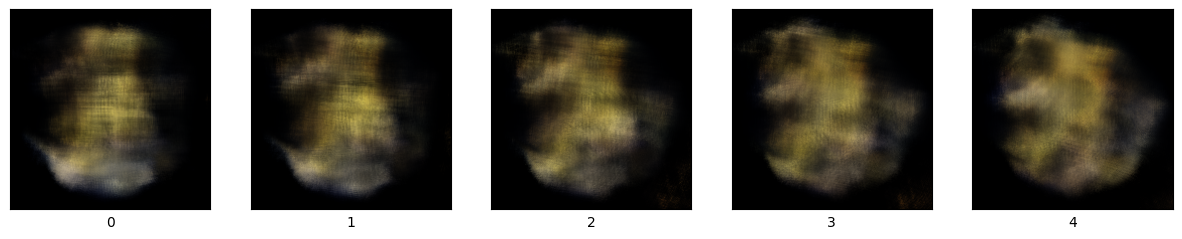

In [35]:
pred = predict(model, param)
show_results(pred[0:5], [str(i) for i in range(5)])

In [17]:
re_image = np.load("results/part2/9.npy")

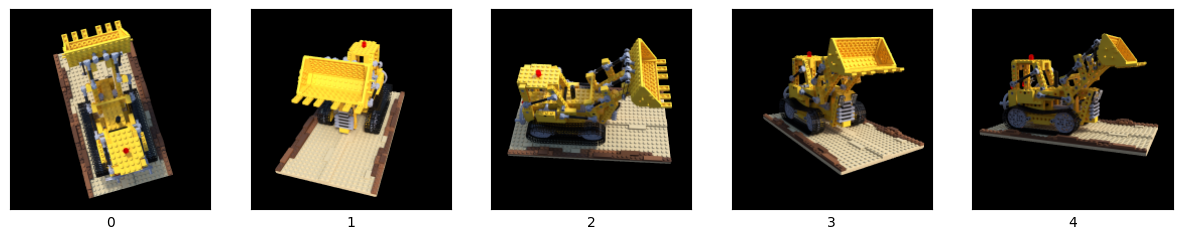

In [18]:
show_results(data['images_val'][0:5], [str(i) for i in range(5)])

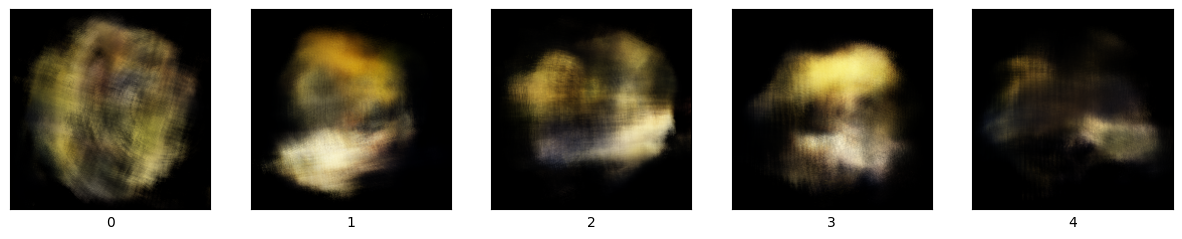

In [19]:
show_results(re_image[0:5], [str(i) for i in range(5)])